In [1]:
import fbprophet
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_excel("/content/gas.xlsx")
df = df[['Sensor Value']]
df

,Sensor Value
0,53
1,54
2,53
3,53
4,53
...,...
1157,93
1158,96
1159,93
1160,93


In [3]:
Days = pd.date_range(start="2017-09-07",end="2020-06-25")
dataframe = pd.DataFrame()
dataframe['ds'] = Days
dataframe['ds'] = dataframe['ds'].dt.date
dataframe['y'] = df[['Sensor Value']]
dataframe

,ds,y
0,2017-09-07,53
1,2017-09-08,54
2,2017-09-09,53
3,2017-09-10,53
4,2017-09-11,53
...,...,...
1018,2020-06-21,114
1019,2020-06-22,114
1020,2020-06-23,114
1021,2020-06-24,113


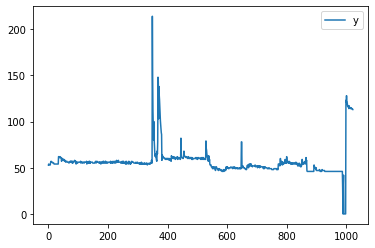

In [4]:
dataframe.plot()

In [5]:
from fbprophet import Prophet
size = (70/100) * len(dataframe)
train = dataframe[0:int(size)]
test = dataframe[int(size):]
model = Prophet()

In [6]:
model.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [7]:
model.component_modes

{'additive': ['weekly',
  'additive_terms',
  'extra_regressors_additive',
  'holidays'],
 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}

In [8]:
futureDates = model.make_future_dataframe(periods=len(test))
predictions = model.predict(futureDates)
predictions = predictions.tail(len(test))
predictions

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
716,2019-08-24,49.511016,35.882982,61.839938,49.511016,49.511016,-0.481402,-0.481402,-0.481402,-0.481402,-0.481402,-0.481402,0.0,0.0,0.0,49.029613
717,2019-08-25,49.490533,35.649847,61.757282,49.490533,49.490533,-0.932378,-0.932378,-0.932378,-0.932378,-0.932378,-0.932378,0.0,0.0,0.0,48.558155
718,2019-08-26,49.470050,36.577719,62.982293,49.470050,49.470050,0.662151,0.662151,0.662151,0.662151,0.662151,0.662151,0.0,0.0,0.0,50.132201
719,2019-08-27,49.449567,36.434705,62.994728,49.449567,49.449567,-0.072731,-0.072731,-0.072731,-0.072731,-0.072731,-0.072731,0.0,0.0,0.0,49.376836
720,2019-08-28,49.429084,37.290452,62.973657,49.429084,49.429084,0.718792,0.718792,0.718792,0.718792,0.718792,0.718792,0.0,0.0,0.0,50.147877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1018,2020-06-21,43.325203,21.884795,62.128749,27.964510,58.298293,-0.932378,-0.932378,-0.932378,-0.932378,-0.932378,-0.932378,0.0,0.0,0.0,42.392825
1019,2020-06-22,43.304720,22.513201,65.064979,27.871020,58.329967,0.662151,0.662151,0.662151,0.662151,0.662151,0.662151,0.0,0.0,0.0,43.966871
1020,2020-06-23,43.284237,22.729378,63.931857,27.734992,58.361641,-0.072731,-0.072731,-0.072731,-0.072731,-0.072731,-0.072731,0.0,0.0,0.0,43.211507
1021,2020-06-24,43.263754,22.439478,64.374887,27.621807,58.409431,0.718792,0.718792,0.718792,0.718792,0.718792,0.718792,0.0,0.0,0.0,43.982547


In [10]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test[['y']],predictions[['yhat']])
mse

491.0193972213114

In [11]:
import pickle
import pickle
with open('/content/gas_model_fbprohpet.pkl', 'wb') as fid:
    pickle.dump(model, fid)

In [12]:
preds = predictions['yhat'].tolist()

In [13]:
forecasting={
    
    'Day-1':preds[0],
    'Day-2':preds[1],
    'Day-3':preds[2],
    'Day-4':preds[3],
    'Day-5':preds[4],
    'Day-6':preds[5],
    'Day-7':preds[6],
    'MSE': mse
}

In [14]:
import firebase_admin
from firebase_admin import credentials
from firebase_admin import db
cred = credentials.Certificate("../content/sensors-forecasting-fc27d-firebase-adminsdk-krgvi-403182645e.json")
firebase_admin.initialize_app(cred,{'databaseURL':'https://sensors-forecasting-fc27d-default-rtdb.firebaseio.com/'})
ref = db.reference("/Models/fbProphet")
upload_ref = ref.child('SuiGas')
upload_ref.update(forecasting)